In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

In [2]:
date = "09-20-24"
data_location = rf"E:\Project 6 - Temperature\Experiments\data_analysis\{date}"

# Load and pre-process data

In [3]:
# Load processed spots, flagged data, remove flagged ones, and calculate mean and std for position_x and radius
position_and_radius_features = pd.DataFrame()
total_positions = 42
positions = range(total_positions)
# positions = [i for i in range(13)] + [i + 26 for i in range(13)]
for pos in positions:
    processed_spots = pd.read_csv(data_location + f"\Pos{pos}_processed_spots.csv")
    try:
        flagged_data = pd.read_csv(data_location + f"\Pos{pos}_flagged_data.csv")
        processed_spots = processed_spots[~processed_spots["TRACK_ID"].isin(flagged_data["TRACK_ID"])]
    except:
        print(f"No flagged data for position {pos}")
    if processed_spots.empty:
        print(f"No spots for position {pos}")
        continue
    # For each TRACK_ID calculate mean and std for position_x and radius
    mean_position_x = processed_spots.groupby("TRACK_ID")["POSITION_X"].mean()
    std_position_x = processed_spots.groupby("TRACK_ID")["POSITION_X"].std()
    mean_radius = processed_spots.groupby("TRACK_ID")["RADIUS"].mean()
    std_radius = processed_spots.groupby("TRACK_ID")["RADIUS"].std()
    # Rename
    mean_position_x = mean_position_x.rename("MEAN_X_TMP")
    std_position_x = std_position_x.rename("STD_X")
    mean_radius = mean_radius.rename("MEAN_RADIUS")
    std_radius = std_radius.rename("STD_RADIUS")
    # Combine
    features = pd.concat([mean_position_x, std_position_x, mean_radius, std_radius], axis=1)
    # Add position
    features["POSITION"] = pos
    # Append
    position_and_radius_features = pd.concat([position_and_radius_features, features])

No flagged data for position 0
No flagged data for position 1
No flagged data for position 2
No flagged data for position 3
No flagged data for position 4
No flagged data for position 5
No flagged data for position 6
No flagged data for position 7
No flagged data for position 8
No flagged data for position 9
No flagged data for position 12
No flagged data for position 13
No flagged data for position 14
No flagged data for position 15
No flagged data for position 16
No flagged data for position 17
No flagged data for position 18
No flagged data for position 19
No flagged data for position 20
No flagged data for position 21
No flagged data for position 22
No flagged data for position 23
No flagged data for position 24
No flagged data for position 25
No flagged data for position 26
No flagged data for position 27
No flagged data for position 28
No flagged data for position 29
No flagged data for position 30
No flagged data for position 31
No flagged data for position 32
No flagged data fo

# Adjust the X position

In [4]:
positions_in_each_row = [
    [i for i in range(14)],
    [i + 14 for i in range(14)],
    [i + 28 for i in range(14)],
    # [i + 26 for i in range(13)]
]
position_offset_row = [
    [2000 * i for i in range(14)],
    # [2000 * i for i in range(13)],
    [2000 * i for i in range(14)][::-1], # Reverse because 13th position is on the hot side
    [2000 * i for i in range(14)],
]
invert_row = [True, True, True]
excluded_positions = [41]

for i in range(len(invert_row)):
    position_offset = position_offset_row[i]
    invert = invert_row[i]
    positions = positions_in_each_row[i]
    for j, pos in enumerate(positions):
        if pos in excluded_positions:
            continue
        x_values = position_and_radius_features[position_and_radius_features["POSITION"] == pos]["MEAN_X_TMP"]
        if invert:
            x_values = 2000 - x_values
        x_values = x_values + position_offset[j]
        position_and_radius_features.loc[position_and_radius_features["POSITION"] == pos, "MEAN_X"] = x_values

# Remove temporary columns
position_and_radius_features = position_and_radius_features.drop(columns=["MEAN_X_TMP"])

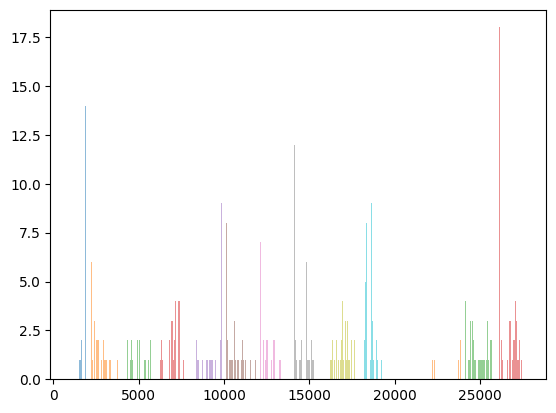

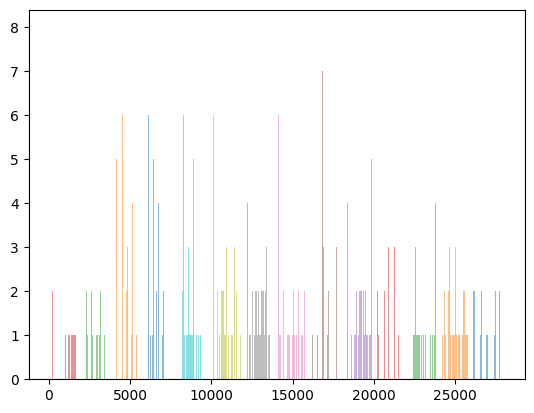

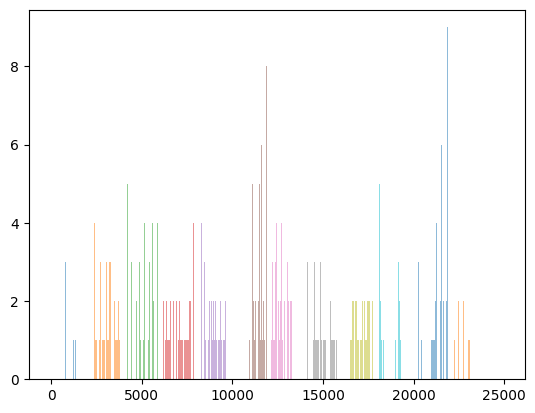

In [5]:
# Make a histogram of mean_x
for row in range(len(invert_row)):
    fig, ax = plt.subplots()
    for pos in positions_in_each_row[row]:
        x_values = position_and_radius_features[position_and_radius_features["POSITION"] == pos]["MEAN_X"]
        ax.hist(x_values, bins=100, alpha=0.5, label=f"Pos{pos}")
    # plt.xlim(0, 26000)
    plt.show()

# Calculate temperature conversion function

In [6]:
# Load temperature log
file_path = data_location + f'/{date}_temp_log.TXT'
temp_log = pd.read_csv(file_path, sep="\s+", usecols=["1ch", "2ch", "3ch", "4ch"])
temp_log["time"] = [15.0 * i for i in range(len(temp_log))]

In [7]:
final_frame_time = 4 * 168 # min
total_space = 14 * 2000
invert_channel_order = True
# Remove any data after final frame time
relevant_temp_log = temp_log[temp_log["time"] <= final_frame_time]
# Calculate mean and std for each channel, remove time column
temp_log_summary = relevant_temp_log.describe().loc[['mean', 'std']]
temp_log_summary = temp_log_summary.drop(columns=["time"])
# Fit a line to the data
x = np.linspace(0.0, total_space, 4) # mm
y = temp_log_summary.loc['mean'].to_numpy()[::]
yerr = temp_log_summary.loc['std'].to_numpy()[::]
if invert_channel_order:
    y = y[::-1]
    yerr = yerr[::-1]

popt, pcov = curve_fit(lambda t, a, b: a * t + b,
                       x, y, p0=[0.1, 15], # sigma=yerr
                       )
xfit = np.linspace(0.0, total_space, 100) # mm
yfit = popt[0] * xfit + popt[1]
# Conversion function
temp_conversion = lambda x: popt[0] * x + popt[1]

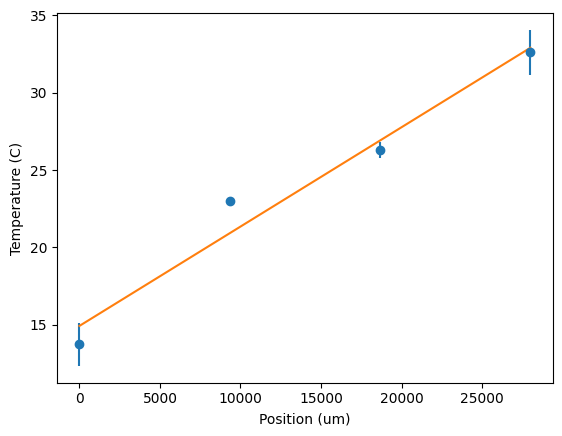

In [8]:
# Plot fit
fig, ax = plt.subplots()
ax.errorbar(x, y, yerr=yerr, fmt='o')
ax.plot(xfit, yfit, label='fit')
ax.set_xlabel("Position (um)")
ax.set_ylabel("Temperature (C)")
plt.show()

# Assign a temperature to each point

In [9]:
# Apply conversion to all positions
position_and_radius_features["MEAN_TEMPERATURE"] = position_and_radius_features["MEAN_X"].apply(temp_conversion)

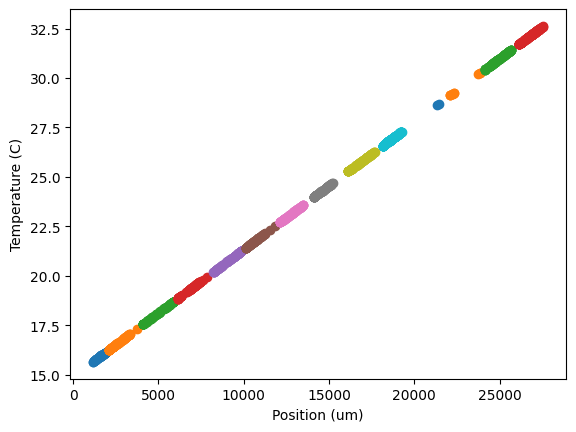

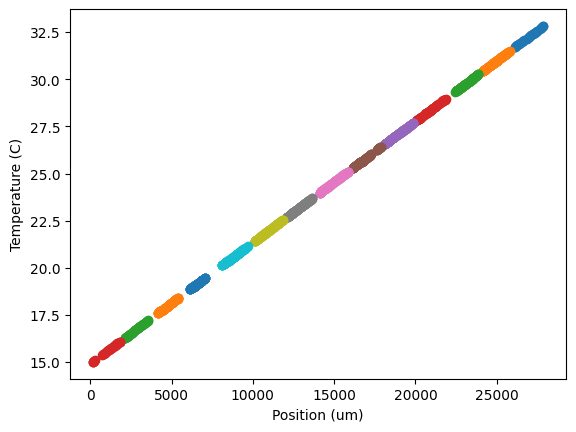

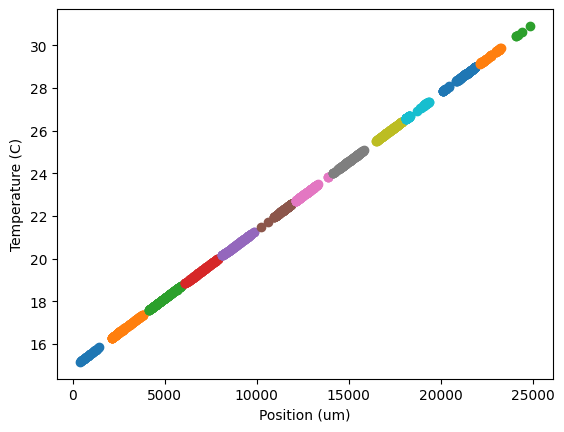

In [10]:
for row in range(len(invert_row)):
    fig, ax = plt.subplots()
    for pos in positions_in_each_row[row]:
        x_values = position_and_radius_features[position_and_radius_features["POSITION"] == pos]["MEAN_X"]
        y_values = position_and_radius_features[position_and_radius_features["POSITION"] == pos]["MEAN_TEMPERATURE"]
        ax.scatter(x_values, y_values, label=f"Pos{pos}")
    ax.set_xlabel("Position (um)")
    ax.set_ylabel("Temperature (C)")
    # ax.set_xlim(0, 26000)
    # ax.set_ylim(14, 42)
    plt.show()

# Save

In [11]:
position_and_radius_features = position_and_radius_features.reset_index()
position_and_radius_features.to_csv(data_location + rf"\{date}_position_and_radius_features.csv")